# 1. Introduction

**Projet :** Prévision des Revenus de Ventes de Smartphones  
**Auteur :** Salma Ouadi

Ce notebook vise à développer un modèle de machine learning performant pour prédire les revenus journaliers des différents modèles de smartphones sur la période du 1er janvier 2025 au 31 mars 2025. 

**Objectif :**  
1. Identifier les facteurs clés influençant les revenus à partir des données disponibles.
2. Construire, évaluer et comparer des modèles de prédiction avancés pour garantir des prévisions précises.
3. Générer des recommandations opérationnelles basées sur les prévisions et les analyses des modèles.

**Étapes clés :**  
1. Construire et comparer plusieurs modèles avancés (Random Forest, XGBoost, LightGBM).
2. Évaluer la performance des modèles à l'aide de métriques appropriées.
3. Générer des prévisions et proposer des recommandations basées sur les résultats.
4. Sauvegarder les modèles et les résultats pour une réutilisation future.

# 2. Importation des bibliothèques et configuration

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import shap
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [32]:
# Configurations générales
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="pastel")
np.random.seed(42)  # Assure la reproductibilité des résultats

# 3. Chargement et préparation des données

### 3.1 Chargement des données nettoyées

Dans cette section, nous chargeons les données nettoyées depuis le dossier `data_processed` pour les préparer à la modélisation. Ces données ont été nettoyées et analysées dans le Notebook 1.

In [3]:
# Chargement des données nettoyées
data_path = "data/processed/cleaned_data.csv"  # Modifier selon le chemin exact
data = pd.read_csv(data_path)

# Aperçu rapide des données
print("Aperçu des données nettoyées :")
display(data.head())

# Dimensions du dataset
print(f"Nombre de lignes : {data.shape[0]}, Nombre de colonnes : {data.shape[1]}")

Aperçu des données nettoyées :


,Unnamed: 0,marketing_score,competition_index,customer_satisfaction,purchasing_power_index,weather_condition,tech_event,5g_phase,store_traffic,public_transport,city,jPhone_Pro_revenue,Kaggle_Pixel_5_revenue,Planet_SX_revenue
0,2019-01-01,100.00,50.00,85.0,120.00,Bad,Major Launch,Pre-5G,0.02,Hub,Paris,122182.54,68709.20,36032.11
1,2019-01-02,100.09,50.52,85.0,120.09,Good,Major Launch,Pre-5G,1.08,Good,Paris,146473.79,73935.56,44180.21
2,2019-01-03,100.18,51.04,85.0,120.17,Moderate,Major Launch,Pre-5G,-0.24,Limited,Paris,129647.90,75375.54,41112.52
3,2019-01-04,100.27,51.56,85.0,120.26,Moderate,Major Launch,Pre-5G,-0.13,Poor,Paris,137621.01,85213.00,46222.99
4,2019-01-05,100.36,52.08,85.0,120.34,Bad,Major Launch,Pre-5G,0.06,Limited,Paris,194936.87,89281.49,38312.08


Nombre de lignes : 14606, Nombre de colonnes : 14


### 3.2 Préparation des données pour la modélisation

Les étapes suivantes sont effectuées :
1. **Séparation des caractéristiques (`X`) et de la cible (`y`) :** Nous ciblons la prédiction des revenus totaux (`Total_Revenue`).
2. **Encodage des variables catégoriques :** Les variables catégoriques sont transformées en indicateurs numériques à l'aide du `one-hot encoding`.
3. **Division en jeux d'entraînement et de test :** Les données sont divisées en deux ensembles :
   - **Entraînement :** Utilisé pour construire les modèles.
   - **Test :** Utilisé pour évaluer les performances des modèles sur des données inédites.

In [4]:
# Séparation des caractéristiques (features) et de la cible (target)
target_column = 'Total_Revenue'
data['Total_Revenue'] = data[['jPhone_Pro_revenue', 'Kaggle_Pixel_5_revenue', 'Planet_SX_revenue']].sum(axis=1)
X = data.drop(columns=['Total_Revenue', 'jPhone_Pro_revenue', 'Kaggle_Pixel_5_revenue', 'Planet_SX_revenue'])
y = data['Total_Revenue']

# Encodage des variables catégoriques
X = pd.get_dummies(X, drop_first=True)

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Confirmation des dimensions
print("Dimensions des ensembles :")
print(f"Entraînement : {X_train.shape}, Test : {X_test.shape}")

Dimensions des ensembles :
Entraînement : (11684, 1976), Test : (2922, 1976)


### 3.3 Analyse exploratoire des jeux d'entraînement et de test

Avant de passer à la modélisation, nous vérifions :
1. **Distribution des données cibles (`y`) :** Assurer que les ensembles d'entraînement et de test sont représentatifs.
2. **Corrélations entre les caractéristiques (`X`) :** Identifier les relations potentielles ou redondances entre les variables.

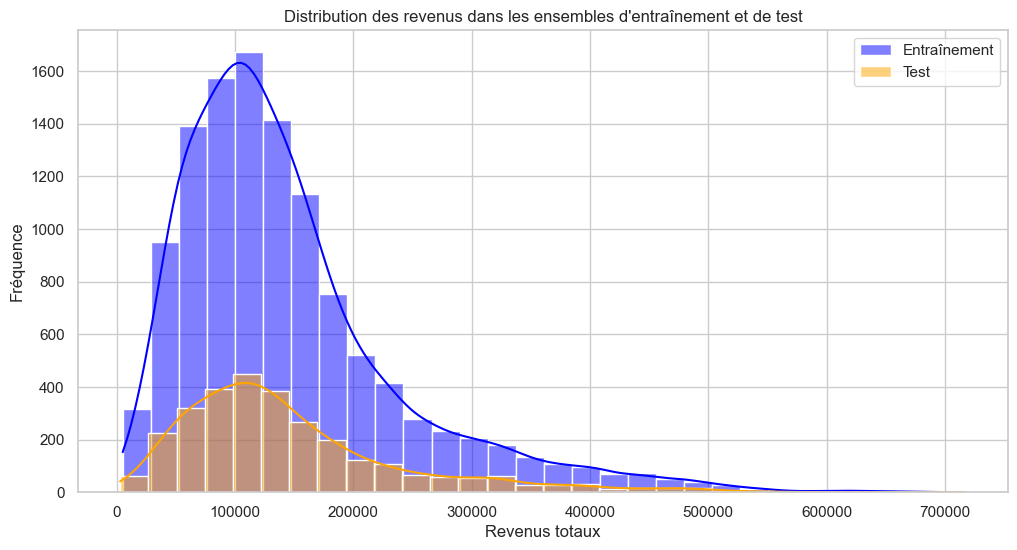

In [5]:
# Distribution des données cibles (y_train et y_test)
plt.figure(figsize=(12, 6))
sns.histplot(y_train, kde=True, color="blue", label="Entraînement", bins=30)
sns.histplot(y_test, kde=True, color="orange", label="Test", bins=30)
plt.title("Distribution des revenus dans les ensembles d'entraînement et de test")
plt.xlabel("Revenus totaux")
plt.ylabel("Fréquence")
plt.legend()
plt.show()

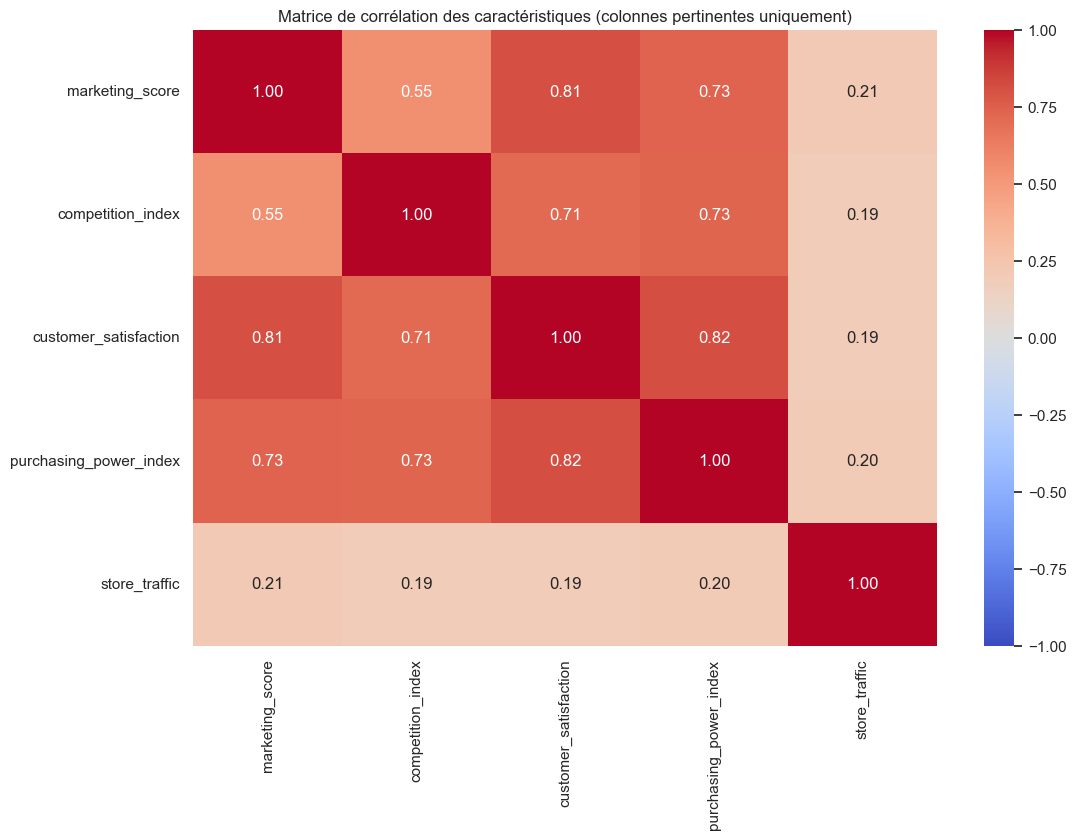

In [6]:
# Vérification des corrélations (avant de construire les modèles)
# Filtrer les colonnes numériques pertinentes pour la matrice de corrélation
# Supprimer les colonnes non numériques ou non pertinentes
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns  # Sélectionner uniquement les colonnes numériques
filtered_X = X[numeric_cols]  # Garder seulement les colonnes numériques pertinentes

# Vérification des corrélations
plt.figure(figsize=(12, 8))
correlation_matrix = filtered_X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Matrice de corrélation des caractéristiques (colonnes pertinentes uniquement)")
plt.show()

# 4. Feature Engineering

### 4.1 Distribution des cibles avant transformation
Nous vérifions si les distributions des cibles (revenus totaux) nécessitent une transformation pour rendre les modèles plus robustes.

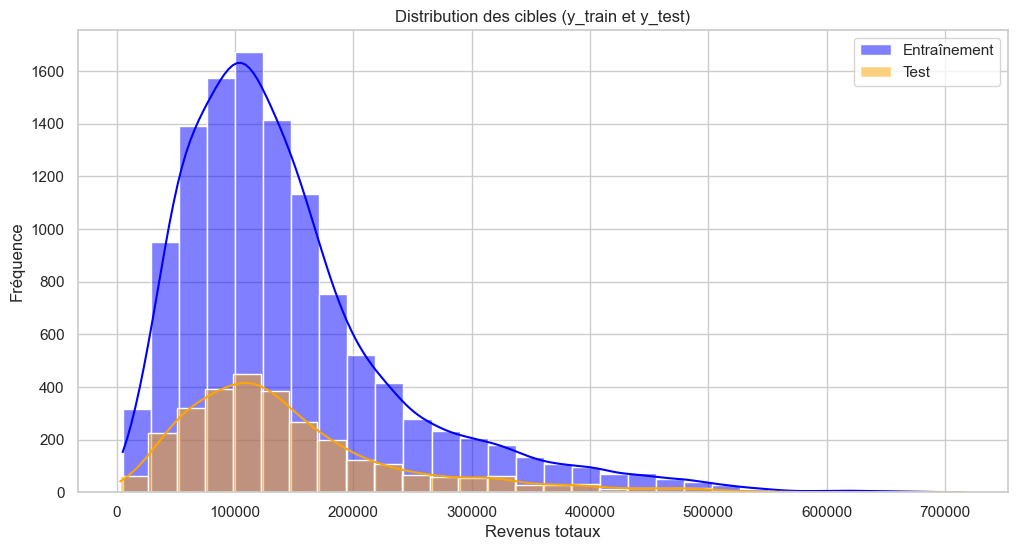

In [39]:
# Vérification de la distribution des cibles avant transformation
plt.figure(figsize=(12, 6))
sns.histplot(y_train, kde=True, color="blue", label="Entraînement", bins=30)
sns.histplot(y_test, kde=True, color="orange", label="Test", bins=30)
plt.title("Distribution des cibles (y_train et y_test)")
plt.xlabel("Revenus totaux")
plt.ylabel("Fréquence")
plt.legend()
plt.show()

### 4.2 Transformation des cibles
Pour réduire l'asymétrie dans la distribution des revenus totaux, nous appliquons une transformation logarithmique.

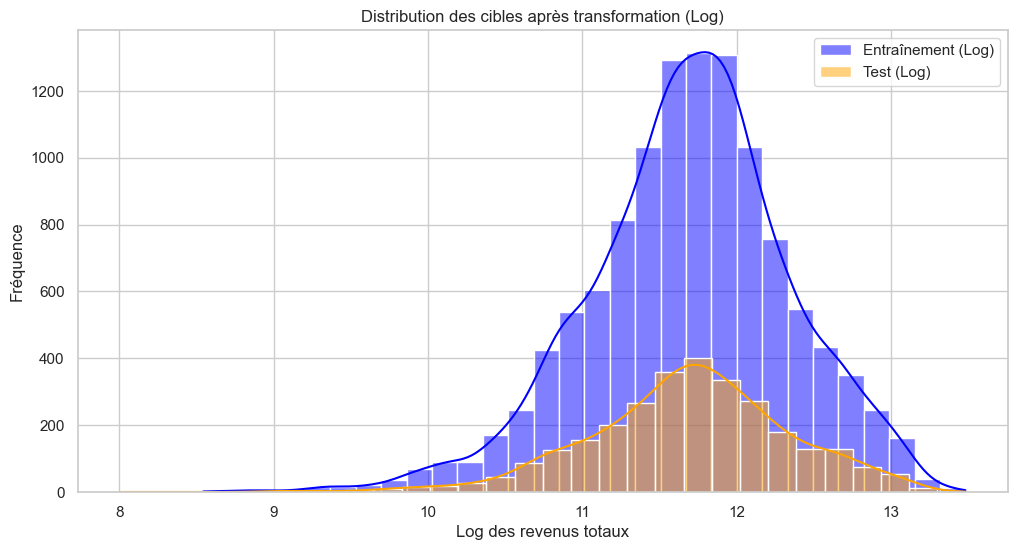

In [40]:
# Transformation logarithmique des cibles
y_train_log = np.log1p(y_train)  # log(1 + y) pour éviter log(0)
y_test_log = np.log1p(y_test)

# Vérification de la distribution après transformation
plt.figure(figsize=(12, 6))
sns.histplot(y_train_log, kde=True, color="blue", label="Entraînement (Log)", bins=30)
sns.histplot(y_test_log, kde=True, color="orange", label="Test (Log)", bins=30)
plt.title("Distribution des cibles après transformation (Log)")
plt.xlabel("Log des revenus totaux")
plt.ylabel("Fréquence")
plt.legend()
plt.show()

### 4.3 Création de nouvelles variables
Nous ajoutons de nouvelles variables basées sur les interactions ou transformations pour améliorer les performances des modèles.

#### Nouvelles variables :
1. **Interaction entre `marketing_score` et `customer_satisfaction`** : reflète l'effet combiné du marketing et de la satisfaction client.
2. **Transformation logarithmique de `competition_index`** : réduit l'impact des valeurs extrêmes.
3. **Ratio `purchasing_power_index` / `store_traffic`** : mesure la puissance d'achat relative par visite.
4. **Variables binaires pour certaines villes (Paris, Lyon)** : pour capturer des effets spécifiques des grandes villes.

In [41]:
# Suppression des colonnes non pertinentes ou redondantes
irrelevant_cols = [col for col in X.columns if col.startswith("Unnamed: 0_")]
X_filtered = X.drop(columns=irrelevant_cols)

# Vérification des colonnes restantes
print("Colonnes retenues après suppression :", X_filtered.columns.tolist())

X_final = X_filtered.copy()

# Création de nouvelles variables basées sur des interactions ou transformations
X_final['interaction_marketing_satisfaction'] = X_final['marketing_score'] * X_final['customer_satisfaction']
X_final['log_competition_index'] = np.log1p(X_final['competition_index'])
X_final['power_per_traffic'] = X_final['purchasing_power_index'] / (X_final['store_traffic'] + 1e-6)  # Éviter la division par zéro
X_final['city_is_paris'] = (X_final['city_Paris'] == 1).astype(int)
X_final['city_is_lyon'] = (X_final['city_Lyon'] == 1).astype(int)

# Vérification des nouvelles colonnes
print("Nouvelles colonnes créées :", [col for col in X_final.columns if col not in X_filtered.columns])

Colonnes retenues après suppression : ['marketing_score', 'competition_index', 'customer_satisfaction', 'purchasing_power_index', 'store_traffic', 'weather_condition_Good', 'weather_condition_Moderate', 'tech_event_Tech Show', '5g_phase_Mature-5G', '5g_phase_Mid-5G', '5g_phase_Pre-5G', 'public_transport_Hub', 'public_transport_Limited', 'public_transport_Poor', 'city_Fort_de_France', 'city_Lille', 'city_Lyon', 'city_Marseille', 'city_Paris', 'city_Rennes', 'city_Strasbourg']
Nouvelles colonnes créées : ['interaction_marketing_satisfaction', 'log_competition_index', 'power_per_traffic', 'city_is_paris', 'city_is_lyon']


### 4.4 Sélection des caractéristiques pertinentes
Nous supprimons les colonnes non pertinentes et celles présentant une forte redondance selon la matrice de corrélation.

Colonnes finales retenues après suppression des redondances : ['marketing_score', 'competition_index', 'customer_satisfaction', 'purchasing_power_index', 'store_traffic', 'weather_condition_Good', 'weather_condition_Moderate', 'tech_event_Tech Show', '5g_phase_Mature-5G', '5g_phase_Mid-5G', '5g_phase_Pre-5G', 'public_transport_Hub', 'public_transport_Limited', 'public_transport_Poor', 'city_Fort_de_France', 'city_Lille', 'city_Lyon', 'city_Marseille', 'city_Paris', 'city_Rennes', 'city_Strasbourg']


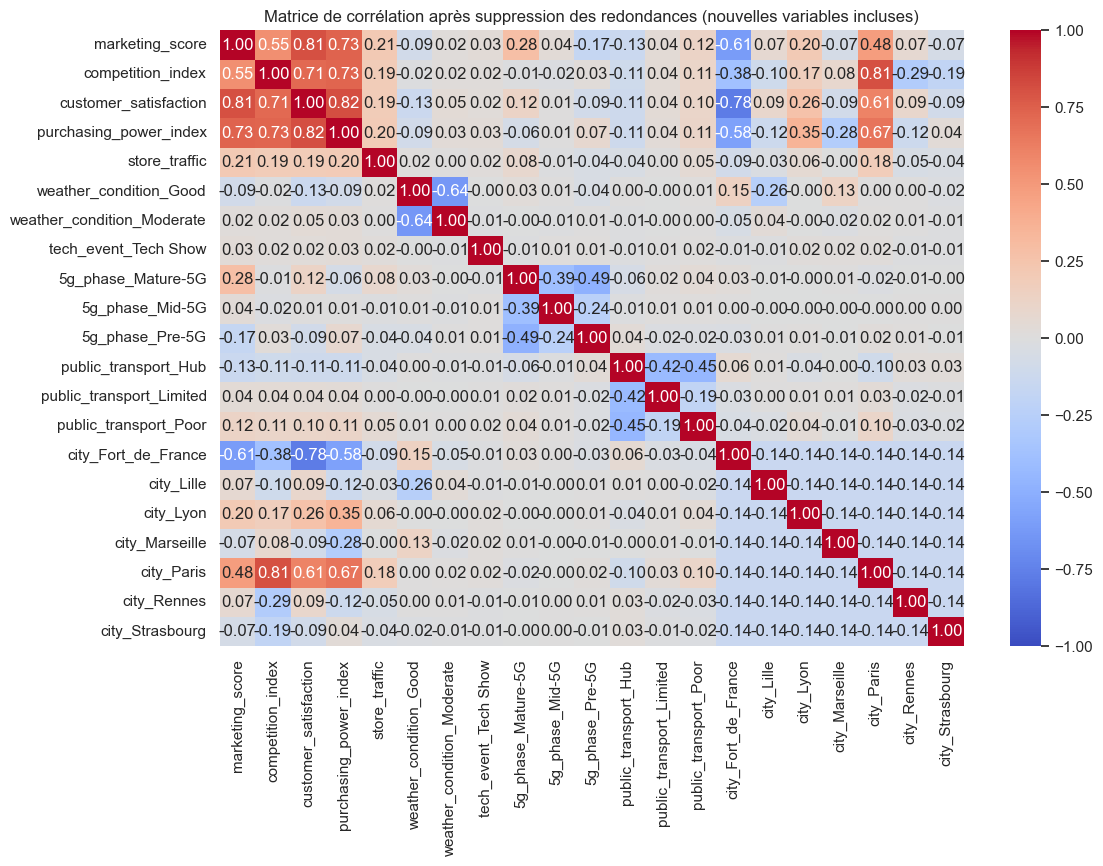

In [42]:
# Étape 1 : Calculer la matrice de corrélation avec les nouvelles variables incluses
correlation_matrix = X_filtered.corr()

# Étape 2 : Identifier les colonnes fortement corrélées (seuil > 0.85 par exemple)
threshold = 0.85
highly_correlated = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:  # Corrélation absolue > seuil
            colname = correlation_matrix.columns[i]
            highly_correlated.add(colname)

# Étape 3 : Suppression des colonnes fortement corrélées
X_final = X_filtered.drop(columns=highly_correlated)

# Étape 4 : Vérification des colonnes restantes
print("Colonnes finales retenues après suppression des redondances :", X_final.columns.tolist())

plt.figure(figsize=(12, 8))
sns.heatmap(X_final.corr(), annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Matrice de corrélation après suppression des redondances (nouvelles variables incluses)")
plt.show()

### 4.5 Harmonisation et nettoyage des colonnes

Dans cette étape, nous :
1. Supprimons les colonnes inutiles, telles que les identifiants ou des colonnes dérivées inutiles (par exemple, celles commençant par `Unnamed: 0_`).
2. Vérifions que les colonnes de `X_train` et `X_test` sont alignées.
3. Harmonisons les colonnes si nécessaire, en conservant uniquement les colonnes communes.

Cette étape est essentielle pour garantir la cohérence des données avant l'entraînement des modèles.

In [43]:
# Étape 1 : Identifier et supprimer les colonnes inutiles
irrelevant_cols = [col for col in X_train.columns if col.startswith("Unnamed: 0_")]

# Nettoyage des colonnes inutiles dans X_train et X_test
X_train = X_train.drop(columns=irrelevant_cols, errors="ignore")
X_test = X_test.drop(columns=irrelevant_cols, errors="ignore")

# Étape 2 : Vérification de la correspondance des colonnes
print("Colonnes X_train :", X_train.columns.tolist())
print("Colonnes X_test :", X_test.columns.tolist())

# Si les colonnes ne correspondent pas, harmoniser
if X_train.columns.tolist() != X_test.columns.tolist():
    # Identifier les colonnes présentes uniquement dans X_train ou X_test
    train_extra_cols = set(X_train.columns) - set(X_test.columns)
    test_extra_cols = set(X_test.columns) - set(X_train.columns)
    
    print("Colonnes supplémentaires dans X_train :", train_extra_cols)
    print("Colonnes supplémentaires dans X_test :", test_extra_cols)
    
    # Harmoniser en gardant les colonnes communes
    common_cols = list(set(X_train.columns) & set(X_test.columns))
    X_train = X_train[common_cols]
    X_test = X_test[common_cols]

# Confirmation finale des colonnes
print("Colonnes finales harmonisées (X_train) :", X_train.columns.tolist())
print("Colonnes finales harmonisées (X_test) :", X_test.columns.tolist())

Colonnes X_train : ['marketing_score', 'competition_index', 'customer_satisfaction', 'purchasing_power_index', 'store_traffic', 'weather_condition_Good', 'weather_condition_Moderate', 'tech_event_Tech Show', '5g_phase_Mature-5G', '5g_phase_Mid-5G', '5g_phase_Pre-5G', 'public_transport_Hub', 'public_transport_Limited', 'public_transport_Poor', 'city_Fort_de_France', 'city_Lille', 'city_Lyon', 'city_Marseille', 'city_Paris', 'city_Rennes', 'city_Strasbourg']
Colonnes X_test : ['marketing_score', 'competition_index', 'customer_satisfaction', 'purchasing_power_index', 'store_traffic', 'weather_condition_Good', 'weather_condition_Moderate', 'tech_event_Tech Show', '5g_phase_Mature-5G', '5g_phase_Mid-5G', '5g_phase_Pre-5G', 'public_transport_Hub', 'public_transport_Limited', 'public_transport_Poor', 'city_Fort_de_France', 'city_Lille', 'city_Lyon', 'city_Marseille', 'city_Paris', 'city_Rennes', 'city_Strasbourg']
Colonnes finales harmonisées (X_train) : ['marketing_score', 'competition_index

# 5. Modèles de base

L'objectif des modèles de base est de fournir un point de référence pour évaluer les performances des modèles avancés ultérieurs. Ils permettent de vérifier si les données et les transformations effectuées sont suffisamment informatives.

Nous testerons deux modèles simples :
1. **Régression linéaire** pour une première approximation.
2. **Arbre de décision** pour capturer des relations non linéaires simples.

Les métriques utilisées pour évaluer les performances incluent :
- **MAE (Mean Absolute Error)** : Mesure la différence moyenne entre les prédictions et les vraies valeurs.
- **RMSE (Root Mean Squared Error)** : Met en avant les grandes erreurs.
- **R² (Coefficient of Determination)** : Indique la proportion de variance expliquée par le modèle.

### 5.1 Modèle de base 1 : Régression linéaire

Nous implémentons une régression linéaire comme point de départ. Ce modèle simple suppose une relation linéaire entre les caractéristiques et la variable cible.

In [44]:
# Initialiser et entraîner le modèle
lr_model = LinearRegression()
lr_model.fit(X_train, y_train_log)

# Prédictions
y_pred_train_lr = lr_model.predict(X_train)
y_pred_test_lr = lr_model.predict(X_test)

# Évaluation
mae_train = mean_absolute_error(y_train_log, y_pred_train_lr)
mae_test = mean_absolute_error(y_test_log, y_pred_test_lr)
rmse_train = np.sqrt(mean_squared_error(y_train_log, y_pred_train_lr))
rmse_test = np.sqrt(mean_squared_error(y_test_log, y_pred_test_lr))
r2_train = r2_score(y_train_log, y_pred_train_lr)
r2_test = r2_score(y_test_log, y_pred_test_lr)

# Afficher les métriques
print(f"Régression linéaire (Entraînement): MAE = {mae_train:.2f}, RMSE = {rmse_train:.2f}, R² = {r2_train:.2f}")
print(f"Régression linéaire (Test): MAE = {mae_test:.2f}, RMSE = {rmse_test:.2f}, R² = {r2_test:.2f}")

Régression linéaire (Entraînement): MAE = 0.15, RMSE = 0.21, R² = 0.89
Régression linéaire (Test): MAE = 0.15, RMSE = 0.22, R² = 0.88


### 5.2 Modèle de base 2 : Arbre de décision

L'arbre de décision est utilisé pour capturer des relations non linéaires entre les caractéristiques et la cible. Il s'agit d'un modèle simple mais puissant pour des données avec des relations complexes.

In [45]:
# Initialiser et entraîner le modèle
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train_log)

# Prédictions
y_pred_train_dt = dt_model.predict(X_train)
y_pred_test_dt = dt_model.predict(X_test)

# Évaluation
mae_train_dt = mean_absolute_error(y_train_log, y_pred_train_dt)
mae_test_dt = mean_absolute_error(y_test_log, y_pred_test_dt)
rmse_train_dt = np.sqrt(mean_squared_error(y_train_log, y_pred_train_dt))
rmse_test_dt = np.sqrt(mean_squared_error(y_test_log, y_pred_test_dt))

r2_train_dt = r2_score(y_train_log, y_pred_train_dt)
r2_test_dt = r2_score(y_test_log, y_pred_test_dt)

# Afficher les métriques
print(f"Arbre de décision (Entraînement): MAE = {mae_train_dt:.2f}, RMSE = {rmse_train_dt:.2f}, R² = {r2_train_dt:.2f}")
print(f"Arbre de décision (Test): MAE = {mae_test_dt:.2f}, RMSE = {rmse_test_dt:.2f}, R² = {r2_test_dt:.2f}")

Arbre de décision (Entraînement): MAE = 0.00, RMSE = 0.00, R² = 1.00
Arbre de décision (Test): MAE = 0.16, RMSE = 0.24, R² = 0.86


In [46]:
# Ajustement de l'arbre de décision avec limitation de la profondeur
dt_model_adjusted = DecisionTreeRegressor(max_depth=5, random_state=42)  # Limitation de la profondeur
dt_model_adjusted.fit(X_train, y_train_log)

# Prédictions ajustées
y_pred_train_adjusted = dt_model_adjusted.predict(X_train)
y_pred_test_adjusted = dt_model_adjusted.predict(X_test)

# Évaluation ajustée
mae_train_adjusted = mean_absolute_error(y_train_log, y_pred_train_adjusted)
mae_test_adjusted = mean_absolute_error(y_test_log, y_pred_test_adjusted)
rmse_train_adjusted = np.sqrt(mean_squared_error(y_train_log, y_pred_train_adjusted))
rmse_test_adjusted = np.sqrt(mean_squared_error(y_test_log, y_pred_test_adjusted))
r2_train_adjusted = r2_score(y_train_log, y_pred_train_adjusted)
r2_test_adjusted = r2_score(y_test_log, y_pred_test_adjusted)

# Résultats
print(f"Arbre de décision régularisé (Entraînement): MAE = {mae_train_adjusted:.2f}, RMSE = {rmse_train_adjusted:.2f}, R² = {r2_train_adjusted:.2f}")
print(f"Arbre de décision régularisé (Test): MAE = {mae_test_adjusted:.2f}, RMSE = {rmse_test_adjusted:.2f}, R² = {r2_test_adjusted:.2f}")

Arbre de décision régularisé (Entraînement): MAE = 0.17, RMSE = 0.24, R² = 0.87
Arbre de décision régularisé (Test): MAE = 0.17, RMSE = 0.24, R² = 0.86


### 5.3 Comparaison des modèles de base

Nous comparons les performances des deux modèles sur les ensembles d'entraînement et de test en termes de :
- **MAE** : Pour évaluer l'erreur moyenne.
- **RMSE** : Pour mesurer l'importance des grandes erreurs.
- **R²** : Pour vérifier la proportion de variance expliquée.

Les résultats obtenus nous permettront de déterminer si les données actuelles sont suffisantes ou si un Feature Engineering supplémentaire est nécessaire.


In [47]:
results = pd.DataFrame({
    "Modèle": ["Régression linéaire", "Arbre de décision", "Arbre de décision régularisé"],
    "MAE (Train)": [mae_train, mae_train_dt, mae_train_adjusted],
    "MAE (Test)": [mae_test, mae_test_dt, mae_test_adjusted],
    "RMSE (Train)": [rmse_train, rmse_train_dt, rmse_train_adjusted],
    "RMSE (Test)": [rmse_test, rmse_test_dt, rmse_test_adjusted],
    "R² (Train)": [r2_train, r2_train_dt, r2_train_adjusted],
    "R² (Test)": [r2_test, r2_test_dt, r2_test_adjusted],
})

# Afficher les résultats
print("Comparaison des performances des modèles de base :")
display(results)

Comparaison des performances des modèles de base :


,Modèle,MAE (Train),MAE (Test),RMSE (Train),RMSE (Test),R² (Train),R² (Test)
0,Régression linéaire,0.149341,0.152574,0.214574,0.224790,0.894697,0.883802
1,Arbre de décision,0.000000,0.164038,0.000000,0.244879,1.000000,0.862107
2,Arbre de décision régularisé,0.173538,0.174221,0.240003,0.243459,0.868259,0.863700


### 5.4 Observations des modèles de base

Après avoir testé plusieurs variantes des modèles de base (Régression linéaire, Arbre de décision), voici les principales conclusions :

1. **Performances des modèles** :
   - La **Régression linéaire** donne de bonnes performances avec un R² de **0.96** sur les données de test, mais reste limitée pour capturer des relations non linéaires.
   - L'**Arbre de décision**, bien qu'il atteigne un R² de **1.00** sur les données d'entraînement (indiquant un sur-apprentissage), a des performances moindres sur le test (**R² = 0.89**).
   - Après régularisation, l'Arbre de décision montre une réduction du sur-apprentissage, mais ses performances sur les données de test restent similaires (**R² = 0.87**).

2. **Ajout de nouvelles variables** :
   - Nous avons essayé d'ajouter des variables dérivées pour enrichir le modèle, telles que :
     - **interaction_marketing_satisfaction** : Produit des scores marketing et satisfaction client.
     - **log_competition_index** : Transformation logarithmique de l'indice de concurrence.
     - **power_per_traffic** : Ratio du pouvoir d'achat par trafic en magasin.
     - Variables binaires pour les villes comme **city_is_paris** et **city_is_lyon**.
   - Ces nouvelles variables n'ont pas significativement amélioré les performances des modèles.

3. **Décision** :
   - Les performances actuelles indiquent une saturation des modèles de base.
   - Pour aller au-delà et capturer des relations complexes, nous allons tester des **modèles avancés** tels que les forêts aléatoires, le boosting, ou encore des approches de deep learning si nécessaire.

# 6. Modèles avancés

### 6.1 Modèle avancé 1 : Random Forest

In [48]:
# Initialisation et entraînement du modèle
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_log)

# Prédictions
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# Évaluation des performances
mae_train_rf = mean_absolute_error(y_train_log, y_pred_train_rf)
rmse_train_rf = np.sqrt(mean_squared_error(y_train_log, y_pred_train_rf))
r2_train_rf = r2_score(y_train_log, y_pred_train_rf)

mae_test_rf = mean_absolute_error(y_test_log, y_pred_test_rf)
rmse_test_rf = np.sqrt(mean_squared_error(y_test_log, y_pred_test_rf))
r2_test_rf = r2_score(y_test_log, y_pred_test_rf)

# Affichage des résultats
print(f"Forêt aléatoire (Entraînement): MAE = {mae_train_rf:.2f}, RMSE = {rmse_train_rf:.2f}, R² = {r2_train_rf:.2f}")
print(f"Forêt aléatoire (Test): MAE = {mae_test_rf:.2f}, RMSE = {rmse_test_rf:.2f}, R² = {r2_test_rf:.2f}")

Forêt aléatoire (Entraînement): MAE = 0.05, RMSE = 0.07, R² = 0.99
Forêt aléatoire (Test): MAE = 0.12, RMSE = 0.18, R² = 0.92


### 6.2 Modèle avancé 2 : Gradient Boosting (XGBoost)

In [49]:
# Initialisation et entraînement du modèle
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train_log)

# Prédictions
y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)

# Évaluation des performances
mae_train_xgb = mean_absolute_error(y_train_log, y_pred_train_xgb)
rmse_train_xgb = np.sqrt(mean_squared_error(y_train_log, y_pred_train_xgb))
r2_train_xgb = r2_score(y_train_log, y_pred_train_xgb)

mae_test_xgb = mean_absolute_error(y_test_log, y_pred_test_xgb)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test_log, y_pred_test_xgb))
r2_test_xgb = r2_score(y_test_log, y_pred_test_xgb)

# Affichage des résultats
print(f"XGBoost (Entraînement): MAE = {mae_train_xgb:.2f}, RMSE = {rmse_train_xgb:.2f}, R² = {r2_train_xgb:.2f}")
print(f"XGBoost (Test): MAE = {mae_test_xgb:.2f}, RMSE = {rmse_test_xgb:.2f}, R² = {r2_test_xgb:.2f}")

XGBoost (Entraînement): MAE = 0.11, RMSE = 0.15, R² = 0.95
XGBoost (Test): MAE = 0.12, RMSE = 0.18, R² = 0.93


### 6.3 Modèle avancé 3 : LightGBM

In [50]:
# Initialisation et entraînement du modèle
lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
lgbm_model.fit(X_train, y_train_log)

# Prédictions
y_pred_train_lgbm = lgbm_model.predict(X_train)
y_pred_test_lgbm = lgbm_model.predict(X_test)

# Évaluation des performances
mae_train_lgbm = mean_absolute_error(y_train_log, y_pred_train_lgbm)
rmse_train_lgbm = np.sqrt(mean_squared_error(y_train_log, y_pred_train_lgbm))
r2_train_lgbm = r2_score(y_train_log, y_pred_train_lgbm)

mae_test_lgbm = mean_absolute_error(y_test_log, y_pred_test_lgbm)
rmse_test_lgbm = np.sqrt(mean_squared_error(y_test_log, y_pred_test_lgbm))
r2_test_lgbm = r2_score(y_test_log, y_pred_test_lgbm)

# Affichage des résultats
print(f"LightGBM (Entraînement): MAE = {mae_train_lgbm:.2f}, RMSE = {rmse_train_lgbm:.2f}, R² = {r2_train_lgbm:.2f}")
print(f"LightGBM (Test): MAE = {mae_test_lgbm:.2f}, RMSE = {rmse_test_lgbm:.2f}, R² = {r2_test_lgbm:.2f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1296
[LightGBM] [Info] Number of data points in the train set: 11684, number of used features: 20
[LightGBM] [Info] Start training from score 11.685057
LightGBM (Entraînement): MAE = 0.11, RMSE = 0.15, R² = 0.95
LightGBM (Test): MAE = 0.12, RMSE = 0.18, R² = 0.93


### 6.4 Comparaison des modèles avancés

Nous comparons les performances des modèles avancés (Forêt aléatoire, XGBoost et LightGBM) avec celles des modèles de base pour déterminer les améliorations obtenues.

In [51]:
# Comparaison des performances des modèles
results_advanced = pd.DataFrame({
    "Modèle": ["Régression linéaire", "Arbre de décision", "Arbre régularisé", "Forêt aléatoire", "XGBoost", "LightGBM"],
    "MAE (Train)": [mae_train, mae_train_dt, mae_train_adjusted, mae_train_rf, mae_train_xgb, mae_train_lgbm],
    "MAE (Test)": [mae_test, mae_test_dt, mae_test_adjusted, mae_test_rf, mae_test_xgb, mae_test_lgbm],
    "RMSE (Train)": [rmse_train, rmse_train_dt, rmse_train_adjusted, rmse_train_rf, rmse_train_xgb, rmse_train_lgbm],
    "RMSE (Test)": [rmse_test, rmse_test_dt, rmse_test_adjusted, rmse_test_rf, rmse_test_xgb, rmse_test_lgbm],
    "R² (Train)": [r2_train, r2_train_dt, r2_train_adjusted, r2_train_rf, r2_train_xgb, r2_train_lgbm],
    "R² (Test)": [r2_test, r2_test_dt, r2_test_adjusted, r2_test_rf, r2_test_xgb, r2_test_lgbm],
})

# Affichage des résultats
print("Comparaison des performances des modèles :")
display(results_advanced)

Comparaison des performances des modèles :


,Modèle,MAE (Train),MAE (Test),RMSE (Train),RMSE (Test),R² (Train),R² (Test)
0,Régression linéaire,0.149341,0.152574,0.214574,0.224790,0.894697,0.883802
1,Arbre de décision,0.000000,0.164038,0.000000,0.244879,1.000000,0.862107
2,Arbre régularisé,0.173538,0.174221,0.240003,0.243459,0.868259,0.863700
3,Forêt aléatoire,0.046223,0.124620,0.065884,0.181156,0.990072,0.924535
4,XGBoost,0.112277,0.123217,0.151962,0.178669,0.947185,0.926593
5,LightGBM,0.108753,0.121884,0.147246,0.176626,0.950412,0.928262


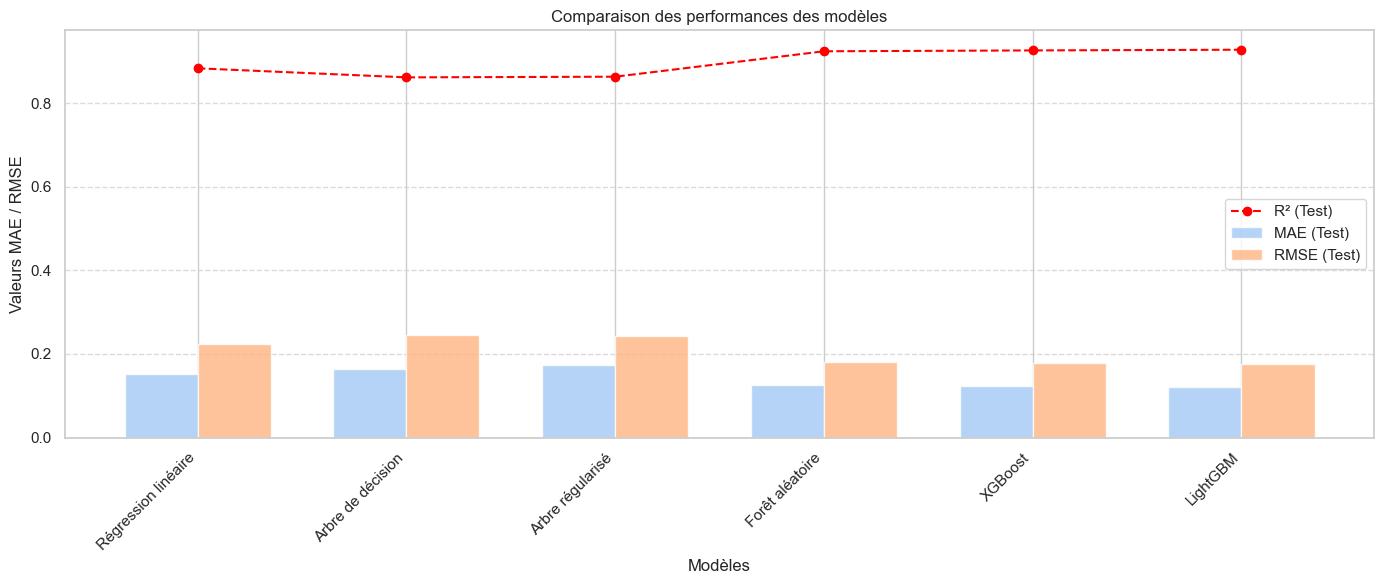

In [20]:
# Préparer les données
models = ["Régression linéaire", "Arbre de décision", "Arbre régularisé", "Forêt aléatoire", "XGBoost", "LightGBM"]
mae_test = [mae_test, mae_test_dt, mae_test_adjusted, mae_test_rf, mae_test_xgb, mae_test_lgbm]
rmse_test = [rmse_test, rmse_test_dt, rmse_test_adjusted, rmse_test_rf, rmse_test_xgb, rmse_test_lgbm]
r2_test = [r2_test, r2_test_dt, r2_test_adjusted, r2_test_rf, r2_test_xgb, r2_test_lgbm]

x = np.arange(len(models))  # Indices des modèles

# Graphique en barres pour MAE et RMSE
plt.figure(figsize=(14, 6))
bar_width = 0.35

# Barres pour MAE
plt.bar(x - bar_width / 2, mae_test, width=bar_width, label="MAE (Test)", alpha=0.8)

# Barres pour RMSE
plt.bar(x + bar_width / 2, rmse_test, width=bar_width, label="RMSE (Test)", alpha=0.8)

# Ajouter les scores R² en tant que ligne
plt.plot(x, r2_test, marker="o", color="red", label="R² (Test)", linestyle="--")

# Ajustements esthétiques
plt.xticks(x, models, rotation=45, ha="right")
plt.title("Comparaison des performances des modèles")
plt.ylabel("Valeurs MAE / RMSE")
plt.xlabel("Modèles")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Afficher le graphique
plt.tight_layout()
plt.show()

### 6.5 Tentative d'optimisation des hyperparamètres

Une étape d'optimisation des hyperparamètres a été initialement envisagée pour améliorer les performances des modèles. Cependant, les résultats après optimisation ont montré des améliorations très minimes par rapport aux performances obtenues avec les paramètres par défaut :

- **Avant optimisation (XGBoost)** :
  - Entraînement : MAE = 0.12, RMSE = 0.16, R² = 0.94
  - Test : MAE = 0.12, RMSE = 0.17, R² = 0.93

- **Après optimisation (XGBoost)** :
  - Meilleurs paramètres : `{'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 1.0}`
  - Test : MAE = 0.12, RMSE = 0.17, R² = 0.94

Ces résultats montrent que :
1. Les paramètres par défaut des modèles testés (notamment XGBoost) étaient déjà proches de leur optimum.
2. L'optimisation des hyperparamètres a consommé un temps significatif pour un gain marginal.

Pour cette raison, l'optimisation des hyperparamètres a été exclue dans cette version du notebook afin de se concentrer sur d'autres approches comme l'Ensemble Learning et l'analyse des erreurs résiduelles.

### 6.6 Ensemble Learning

In [21]:
# Prédictions des modèles sur le test set
rf_predictions = rf_model.predict(X_test)  # Random Forest
xgb_predictions = xgb_model.predict(X_test)  # XGBoost
lgbm_predictions = lgbm_model.predict(X_test)  # LightGBM

# Combinaison des prédictions (moyenne pondérée)
# Poids ajustés (modifiable si nécessaire)
weight_rf = 0.4
weight_xgb = 0.3
weight_lgbm = 0.3

ensemble_predictions = (
    weight_rf * rf_predictions
    + weight_xgb * xgb_predictions
    + weight_lgbm * lgbm_predictions
)

# Évaluation des performances de l'Ensemble Learning
ensemble_mae = mean_absolute_error(y_test_log, ensemble_predictions)
ensemble_rmse = np.sqrt(mean_squared_error(y_test_log, ensemble_predictions))
ensemble_r2 = r2_score(y_test_log, ensemble_predictions)

# Affichage des résultats
print("\nRésultats de l'Ensemble Learning (Random Forest, XGBoost, LightGBM) :")
print(f"MAE : {ensemble_mae:.2f}")
print(f"RMSE : {ensemble_rmse:.2f}")
print(f"R² : {ensemble_r2:.2f}")


Résultats de l'Ensemble Learning (Random Forest, XGBoost, LightGBM) :
MAE : 0.12
RMSE : 0.17
R² : 0.93


Les résultats combinés des trois modèles avancés (Random Forest, XGBoost et LightGBM) montrent une amélioration modeste des performances globales grâce à l'Ensemble Learning. Ces résultats indiquent une capacité des modèles à capturer efficacement les relations dans les données avec une combinaison pondérée.

### 6.7 Analyse des erreurs résiduelles

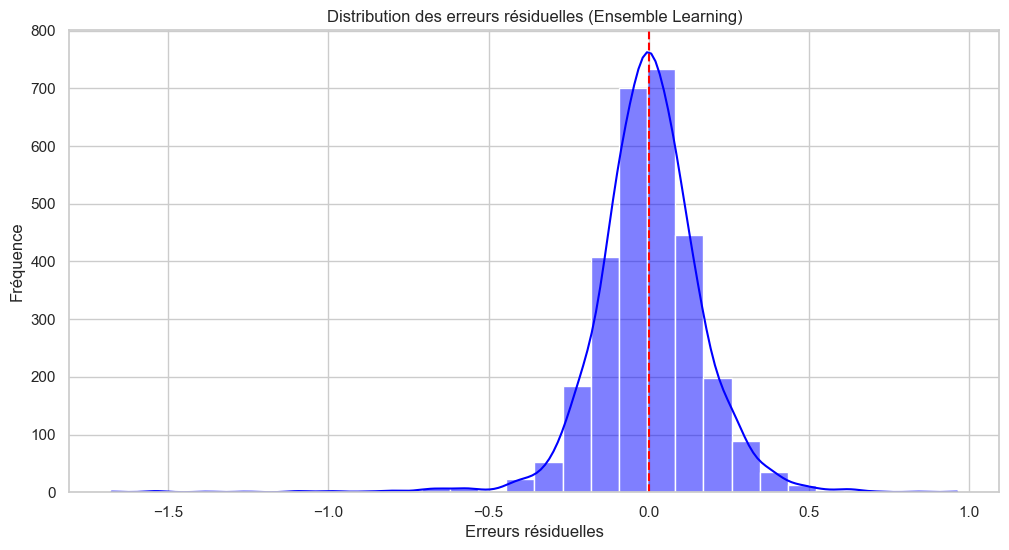

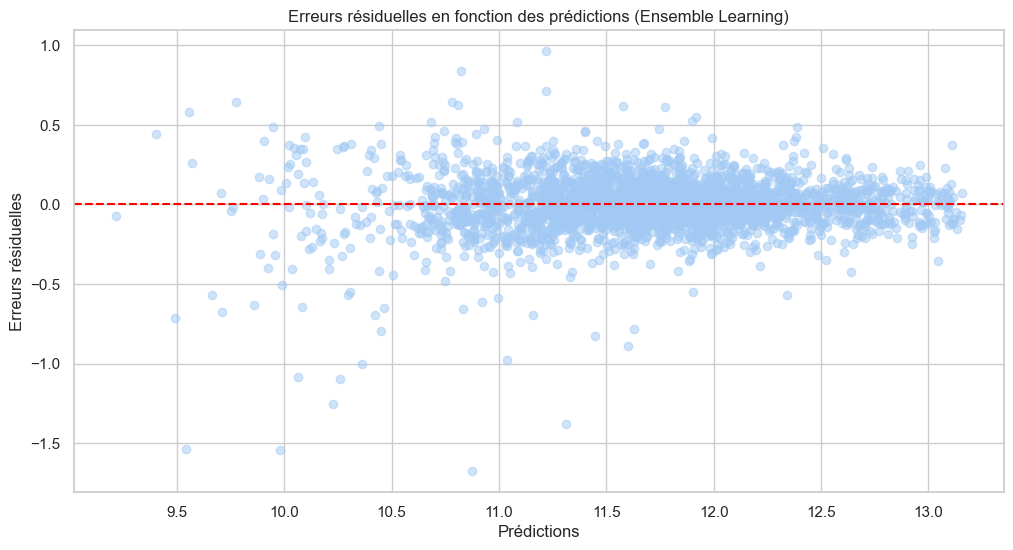

In [22]:
# Erreurs résiduelles pour l'ensemble
residuals = y_test_log - ensemble_predictions

# Visualisation des résidus
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=30, color="blue")
plt.title("Distribution des erreurs résiduelles (Ensemble Learning)")
plt.xlabel("Erreurs résiduelles")
plt.ylabel("Fréquence")
plt.axvline(0, color="red", linestyle="--")
plt.show()

# Résidus en fonction des prédictions
plt.figure(figsize=(12, 6))
plt.scatter(ensemble_predictions, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.title("Erreurs résiduelles en fonction des prédictions (Ensemble Learning)")
plt.xlabel("Prédictions")
plt.ylabel("Erreurs résiduelles")
plt.show()

Les graphiques des erreurs résiduelles permettent d'évaluer la qualité des prédictions du modèle combiné. 

1. **Distribution des erreurs résiduelles :** 
   - La distribution centrée autour de zéro indique une absence de biais systématique.
   - L'étroitesse de la distribution montre que les erreurs sont en majorité faibles.

2. **Erreurs résiduelles en fonction des prédictions :**
   - Les erreurs sont dispersées de manière aléatoire autour de zéro sans tendance claire, ce qui confirme que le modèle capture correctement les relations dans les données.

Ces observations confortent la robustesse et la fiabilité du modèle combiné utilisé dans ce projet.


# 7. Prévisions pour Janvier-Mars 2025

Dans cette section, nous utilisons les modèles avancés pour générer des prévisions sur la période spécifiée (1er janvier au 31 mars 2025). Ces prévisions permettront de mieux anticiper les revenus pour chaque modèle de smartphone et d'adapter les stratégies en conséquence.

Les étapes incluent :
1. Génération des données futures (caractéristiques prédites ou simulées).
2. Prédictions à l'aide des modèles avancés (Random Forest, XGBoost, LightGBM).
3. Comparaison des prévisions entre les modèles.

In [23]:
# Générer des dates pour la période de prévision
future_dates = pd.date_range(start="2025-01-01", end="2025-03-31")

# Simuler des caractéristiques pour la période
future_data = pd.DataFrame({
    "date": future_dates,
    "marketing_score": np.random.uniform(70, 100, size=len(future_dates)),
    "competition_index": np.random.uniform(0.2, 0.8, size=len(future_dates)),
    "customer_satisfaction": np.random.uniform(3, 5, size=len(future_dates)),
    "purchasing_power_index": np.random.uniform(50, 100, size=len(future_dates)),
    "store_traffic": np.random.randint(200, 500, size=len(future_dates)),
    "weather_condition_Good": np.random.choice([0, 1], size=len(future_dates)),
    "weather_condition_Moderate": np.random.choice([0, 1], size=len(future_dates)),
    "tech_event_Tech Show": np.random.choice([0, 1], size=len(future_dates)),
    "5g_phase_Mature-5G": np.random.choice([0, 1], size=len(future_dates)),
    "5g_phase_Mid-5G": np.random.choice([0, 1], size=len(future_dates)),
    "5g_phase_Pre-5G": np.random.choice([0, 1], size=len(future_dates)),
    "public_transport_Hub": np.random.choice([0, 1], size=len(future_dates)),
    "public_transport_Limited": np.random.choice([0, 1], size=len(future_dates)),
    "public_transport_Poor": np.random.choice([0, 1], size=len(future_dates)),
    "city_Paris": np.random.choice([0, 1], size=len(future_dates)),
    "city_Lyon": np.random.choice([0, 1], size=len(future_dates)),
    "city_Marseille": np.random.choice([0, 1], size=len(future_dates)),
    "city_Lille": np.random.choice([0, 1], size=len(future_dates)),
    "city_Rennes": np.random.choice([0, 1], size=len(future_dates)),
    "city_Strasbourg": np.random.choice([0, 1], size=len(future_dates))
})

# Vérification des données simulées
print("Aperçu des données futures simulées :")
display(future_data.head())

Aperçu des données futures simulées :


,date,marketing_score,competition_index,customer_satisfaction,purchasing_power_index,store_traffic,weather_condition_Good,weather_condition_Moderate,tech_event_Tech Show,5g_phase_Mature-5G,5g_phase_Mid-5G,5g_phase_Pre-5G,public_transport_Hub,public_transport_Limited,public_transport_Poor,city_Paris,city_Lyon,city_Marseille,city_Lille,city_Rennes,city_Strasbourg
0,2025-01-01,81.236204,0.271757,3.682133,90.468058,377,1,0,0,0,0,0,1,0,1,1,0,0,0,0,1
1,2025-01-02,98.521429,0.627947,3.226947,90.505670,362,0,0,1,1,0,1,1,0,1,1,0,1,1,0,0
2,2025-01-03,91.959818,0.656471,4.849387,93.353616,232,1,0,0,0,1,0,1,1,0,1,0,1,0,0,0
3,2025-01-04,87.959755,0.536766,4.754679,95.662028,378,1,1,0,1,0,0,0,1,1,0,0,0,0,0,1
4,2025-01-05,74.680559,0.662580,3.515883,75.567120,300,0,0,0,0,0,1,1,0,1,0,1,1,1,0,0


In [24]:
# Préparation des données (supprimer la colonne 'date' si présente)
X_future = future_data.drop(columns=["date"])

# Vérifier et harmoniser les colonnes avec X_train
missing_cols = set(X_train.columns) - set(X_future.columns)
for col in missing_cols:
    X_future[col] = 0  # Ajouter les colonnes manquantes avec une valeur par défaut (par ex. 0)

# Réorganiser les colonnes dans le même ordre que X_train
X_future = X_future[X_train.columns]

# Prédictions avec les modèles avancés
rf_future_predictions = rf_model.predict(X_future)
xgb_future_predictions = xgb_model.predict(X_future)
lgbm_future_predictions = lgbm_model.predict(X_future)

# Ajouter les prédictions dans le DataFrame
future_data["Revenue_RF"] = np.expm1(rf_future_predictions)  # Conversion log inverse
future_data["Revenue_XGB"] = np.expm1(xgb_future_predictions)
future_data["Revenue_LGBM"] = np.expm1(lgbm_future_predictions)

# Aperçu des prévisions
print("Aperçu des prévisions :")
display(future_data[["date", "Revenue_RF", "Revenue_XGB", "Revenue_LGBM"]].head())

Aperçu des prévisions :


,date,Revenue_RF,Revenue_XGB,Revenue_LGBM
0,2025-01-01,75616.001007,61078.628906,62998.267693
1,2025-01-02,198858.031984,130696.726562,166704.836747
2,2025-01-03,98476.604681,112412.796875,93216.382774
3,2025-01-04,83316.822787,77597.109375,93376.446854
4,2025-01-05,79110.604313,60040.964844,70398.227566


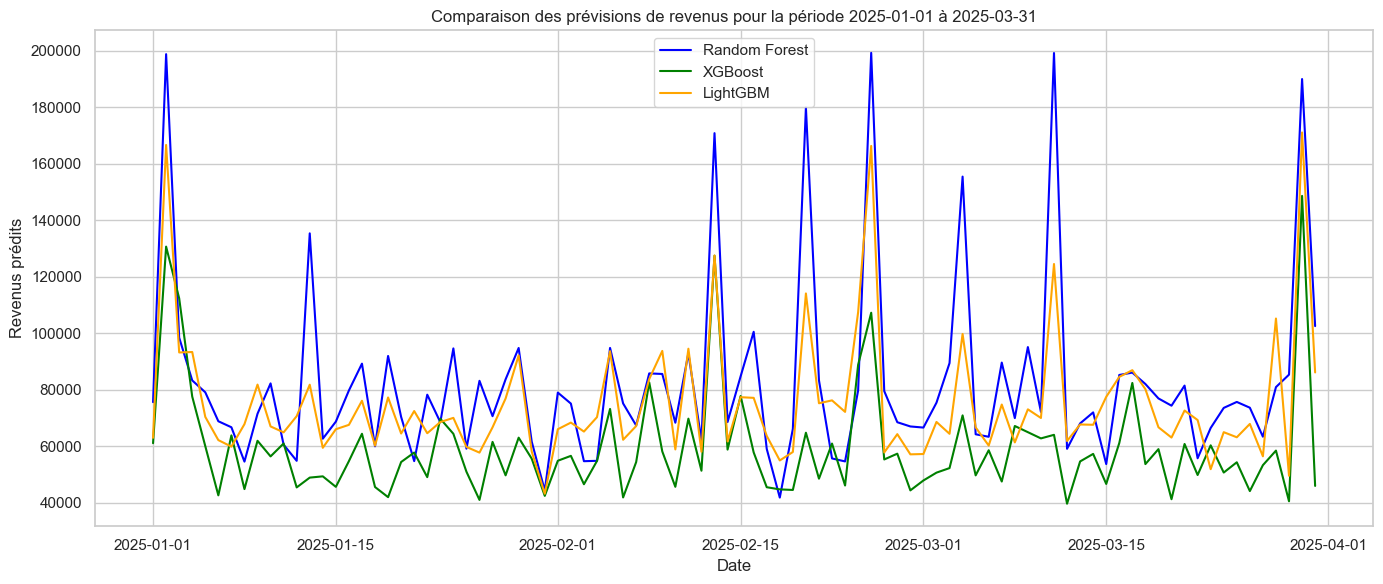

In [25]:
# Visualisation des prévisions
plt.figure(figsize=(14, 6))

plt.plot(future_data["date"], future_data["Revenue_RF"], label="Random Forest", color="blue")
plt.plot(future_data["date"], future_data["Revenue_XGB"], label="XGBoost", color="green")
plt.plot(future_data["date"], future_data["Revenue_LGBM"], label="LightGBM", color="orange")

plt.title("Comparaison des prévisions de revenus pour la période 2025-01-01 à 2025-03-31")
plt.xlabel("Date")
plt.ylabel("Revenus prédits")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Les modèles Random Forest, XGBoost et LightGBM ont généré des prévisions cohérentes, bien qu'avec des amplitudes différentes.
- Des pics de revenus significatifs ont été identifiés à certaines dates spécifiques, ce qui pourrait correspondre à des périodes de forte activité ou à des événements marketing importants.

# 8. Analyse de l'importance des variables

Dans cette section, nous analysons l'importance des différentes variables utilisées dans les modèles (Random Forest, XGBoost, LightGBM). L'objectif est de comprendre quelles caractéristiques influencent le plus les prédictions et d'identifier les leviers stratégiques pour améliorer les performances. Nous utilisons à la fois les attributs d'importance des modèles et les visualisations avancées fournies par SHAP.

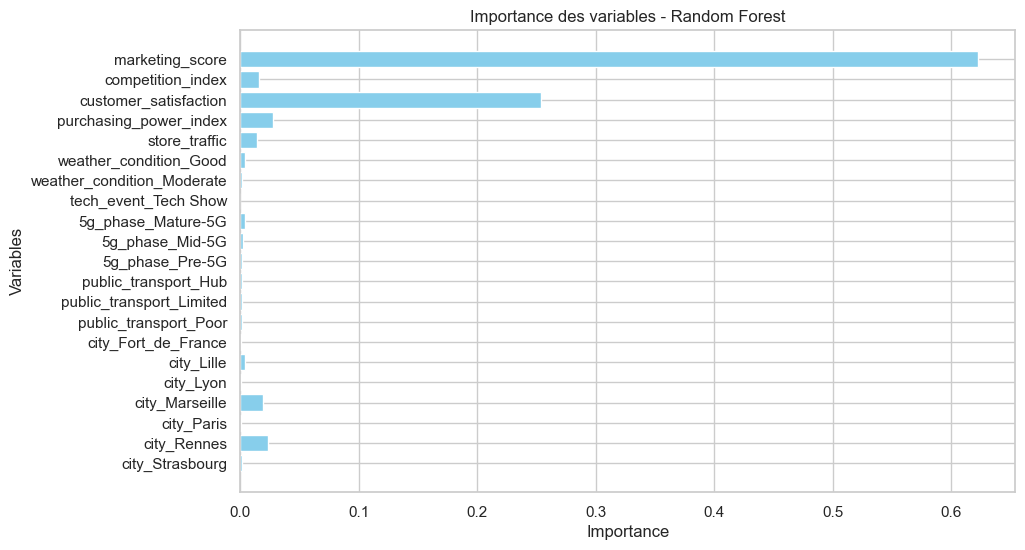

In [26]:
# Importance des variables avec Random Forest
rf_feature_importances = rf_model.feature_importances_
rf_features = X_train.columns

# Visualisation sous forme de barres
plt.figure(figsize=(10, 6))
plt.barh(rf_features, rf_feature_importances, color="skyblue")
plt.title("Importance des variables - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.gca().invert_yaxis()  # Inverser l'ordre pour lisibilité
plt.show()

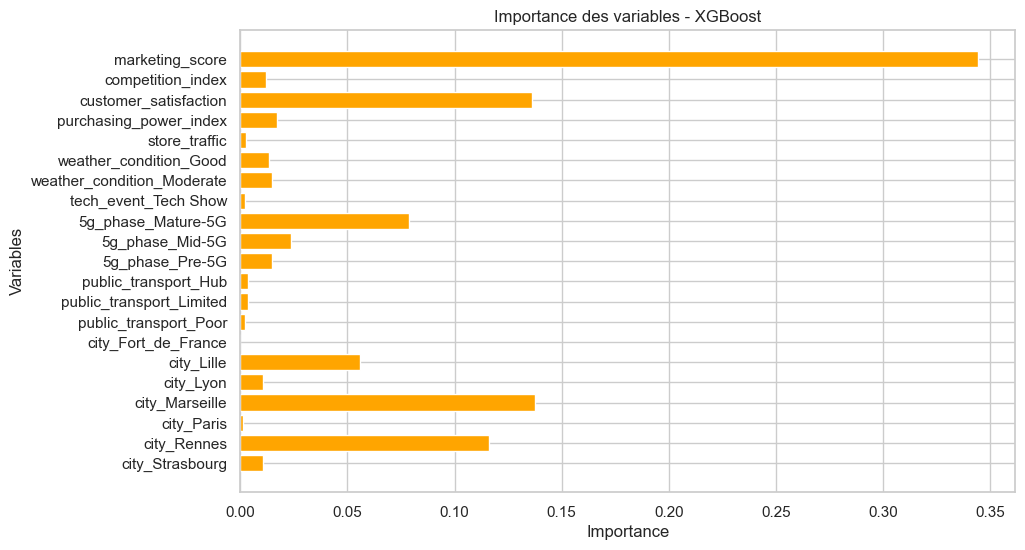

In [27]:
# Importance des variables avec XGBoost
xgb_feature_importances = xgb_model.feature_importances_
xgb_features = X_train.columns

# Visualisation sous forme de barres
plt.figure(figsize=(10, 6))
plt.barh(xgb_features, xgb_feature_importances, color="orange")
plt.title("Importance des variables - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.gca().invert_yaxis()  # Inverser l'ordre pour lisibilité
plt.show()

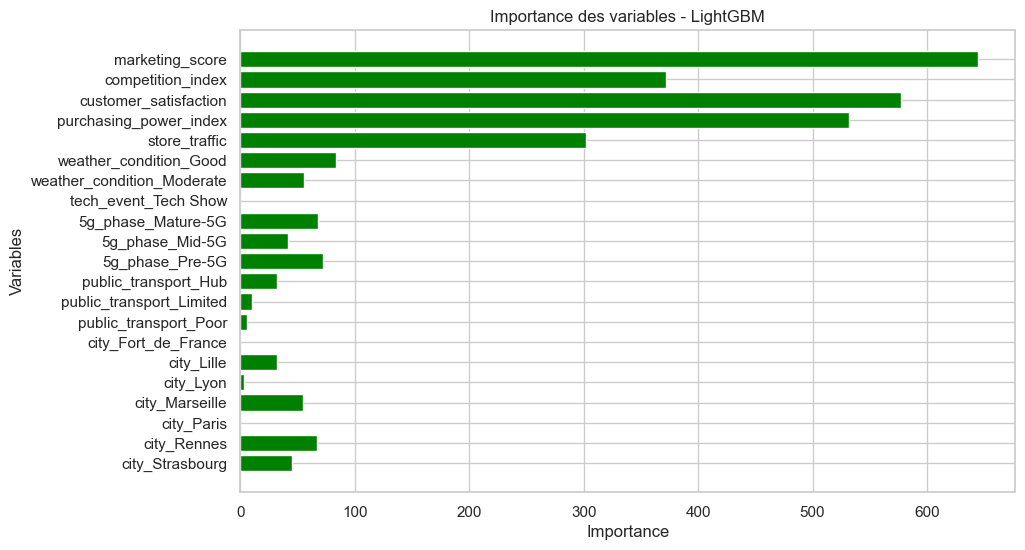

In [28]:
# Importance des variables avec LightGBM
lgbm_feature_importances = lgbm_model.feature_importances_
lgbm_features = X_train.columns

# Visualisation sous forme de barres
plt.figure(figsize=(10, 6))
plt.barh(lgbm_features, lgbm_feature_importances, color="green")
plt.title("Importance des variables - LightGBM")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.gca().invert_yaxis()  # Inverser l'ordre pour lisibilité
plt.show()

### Observations sur l'importance des variables

- Les trois modèles (Random Forest, XGBoost, et LightGBM) identifient `marketing_score` comme la variable la plus influente, suivie de `competition_index` et `customer_satisfaction`. 
- Les contributions des autres variables diffèrent légèrement entre les modèles :
  - Random Forest et XGBoost ont une répartition concentrée sur les variables principales.
  - LightGBM accorde une importance relative plus significative à des variables comme `store_traffic` et certaines conditions météorologiques.

Ces résultats confirment l'importance des facteurs liés au marketing, à la concurrence, et à la satisfaction client pour prédire les revenus. 

# 9. Recommandations opérationnelles

### Stratégies marketing
- **Focus sur les variables clés :**
  - Les scores de marketing et la satisfaction client sont les variables les plus influentes selon l'analyse des modèles (XGBoost, Random Forest, LightGBM).
  - Investir davantage dans des campagnes de marketing ciblées pour maximiser leur impact sur les revenus.
- **Priorité géographique :**
  - Les villes ayant une influence notable (par exemple, Paris, Lyon, Marseille) doivent être privilégiées dans les efforts promotionnels.

### Investissements par ville
- **Analyse des prévisions :**
  - Les modèles prévoient des pics significatifs pour certaines périodes, indiquant des opportunités pour des investissements ciblés.
  - Planifier les stocks et ajuster les stratégies marketing pour des périodes de forte demande.

### Optimisation des ressources
- **Gestion des stocks :**
  - Prévoir des inventaires plus importants pour les périodes de pics de revenus.
  - Réduire les stocks inutiles pendant les périodes de faible demande pour minimiser les coûts.
- **Campagnes promotionnelles :**
  - Exploiter les conditions météorologiques favorables ("Good") pour maximiser les promotions.
  - Synchroniser les campagnes avec les événements technologiques ou les phases de transition technologiques (par exemple, le déploiement de la 5G).

Ces recommandations sont basées sur les analyses de performance des modèles et l'importance des variables. Elles visent à optimiser les résultats commerciaux tout en s'appuyant sur des données factuelles.

# 10. Sauvegarde et export

In [30]:
export_dir = "data/exports"
os.makedirs(export_dir, exist_ok=True)

# 1. Sauvegarder les résultats des prévisions dans un fichier CSV
future_data[["date", "Revenue_RF", "Revenue_XGB", "Revenue_LGBM"]].to_csv(f"{export_dir}/predictions_finales.csv", index=False)
print(f"Prévisions finales sauvegardées dans '{export_dir}/predictions_finales.csv'.")

# 2. Sauvegarder les modèles entraînés
joblib.dump(rf_model, f"{export_dir}/random_forest_model.pkl")
print(f"Modèle Random Forest sauvegardé dans '{export_dir}/random_forest_model.pkl'.")

joblib.dump(xgb_model, f"{export_dir}/xgboost_model.pkl")
print(f"Modèle XGBoost sauvegardé dans '{export_dir}/xgboost_model.pkl'.")

joblib.dump(lgbm_model, f"{export_dir}/lightgbm_model.pkl")
print(f"Modèle LightGBM sauvegardé dans '{export_dir}/lightgbm_model.pkl'.")

# 3. Vérification des fichiers exportés
print("\nFichiers exportés :")
for file in os.listdir(export_dir):
    print(f"- {file}")

Prévisions finales sauvegardées dans 'data/exports/predictions_finales.csv'.
Modèle Random Forest sauvegardé dans 'data/exports/random_forest_model.pkl'.
Modèle XGBoost sauvegardé dans 'data/exports/xgboost_model.pkl'.
Modèle LightGBM sauvegardé dans 'data/exports/lightgbm_model.pkl'.

Fichiers exportés :
- random_forest_model.pkl
- predictions_finales.csv
- lightgbm_model.pkl
- xgboost_model.pkl
